<a href="https://colab.research.google.com/github/TeDand/neuromorphic-classification/blob/main/custom_frame_integration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notebook Setup

## Hardware Setup

In [ ]:
import tensorflow as tf

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

gpu = tf.test.gpu_device_name()
print(gpu)

Sat Jun 25 16:00:34 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Mounting Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Random Tests

In [ ]:
!rm -rf /content/rpg_e2vid/data/DVS128Gesture
!rm -rf /content/datasets/DVS128Gesture
!mkdir /content/datasets
!unzip -q /content/drive/MyDrive/DVS128Gesture/'DVS  Gesture dataset.zip' -d /content/tmp
!tar -xzf /content/tmp/'DVS  Gesture dataset'/DvsGesture.tar.gz -C /content/datasets
!rm -rf tmp

In [ ]:
!pip3 install -q dv
from dv import LegacyAedatFile
import os
import shutil
from typing import NamedTuple

class Event(NamedTuple):
    x_location: int
    y_location: int
    polarity: int
    timestamp: int

def read_aedat_events(input_file):
  events = []
  with LegacyAedatFile(input_file) as f:
    for event in f:
      events.append(Event(event.x, event.y, event.polarity, event.timestamp))

  return events

def segment_events(event_list, segments, visualise):
  sorted_events = sorted(event_list, key=lambda e: e.timestamp, reverse=False)
  timestamp_range = sorted_events[-1].timestamp - sorted_events[0].timestamp
  if visualise:
    print("{0} -> {1} ms = {2} ms".format(sorted_events[0].timestamp, sorted_events[-1].timestamp, timestamp_range))

  segmented_events = []
  for i in range(segments):
    segmented_events.append(list(filter(
        lambda event: event.timestamp < (i+1)*(sorted_events[-1].timestamp/segments)
        and event.timestamp > (i)*(sorted_events[-1].timestamp/segments), event_list)))
    if i%3 == 1 and visualise == 1:
      visualise_events(segmented_events[-1])

  return segmented_events

def get_intensity(event_list, max_x, max_y):
  off_events = list(filter(lambda event: event.polarity == 0, event_list))
  on_events = list(filter(lambda event: event.polarity == 1, event_list))

  intensity = [[0 for _ in range(max_x)] for _ in range(max_y)]

  for e in on_events:
    intensity[e.x_location][e.y_location] += 1

  for e in off_events:
    intensity[e.x_location][e.y_location] -= 1

  return intensity

max_samples = 1

def load_dvs_samples(train):
  folder = "train" if train else "test"

  with open("/content/datasets/DvsGesture/trials_to_{0}.txt".format(folder)) as file:
      lines = file.readlines()
      train_files = [line.rstrip() for line in lines]
  print("Loading {0}ing samples:".format(folder))
  count = 0
  videos = []
  for file_name in train_files:
    if count < (max_samples if train else max_samples /4):
      input_directory = "/content/datasets/DvsGesture/{0}".format(file_name)
      print("- {0}".format(file_name))
      e = read_aedat_events(input_directory)
      s = segment_events(e, 20, False)
      i = [get_intensity(s_i, 128, 128) for s_i in s]
      videos.append(i)
    count = count + 1

    return videos

videos = load_dvs_samples(train=True)

Loading training samples:
- user01_fluorescent.aedat


In [ ]:
import numpy as np

print(np.array(videos).shape)

(1, 100, 128, 128)


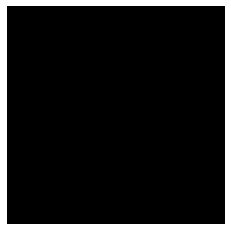

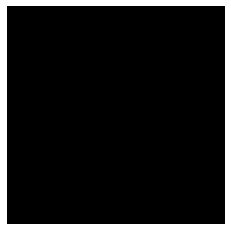

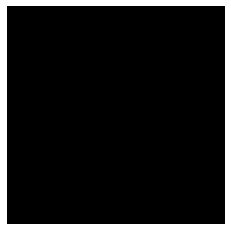

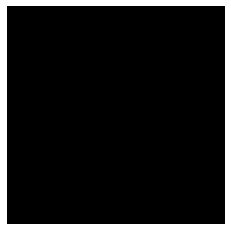

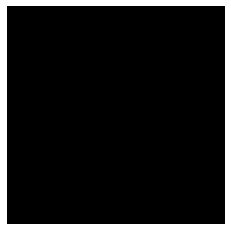

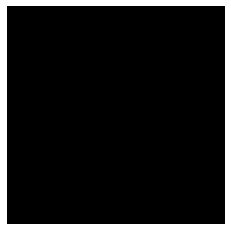

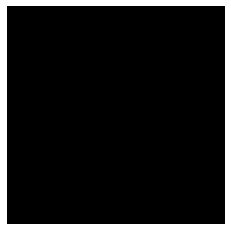

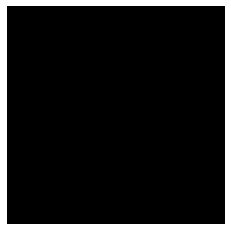

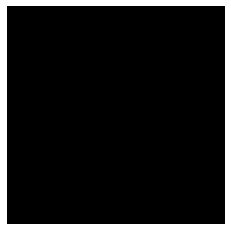

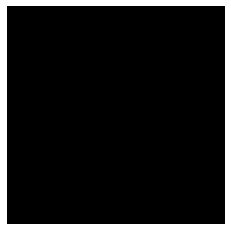

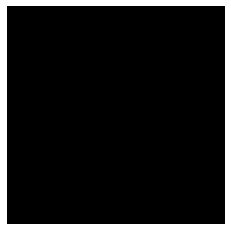

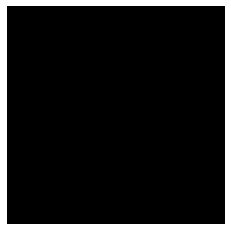

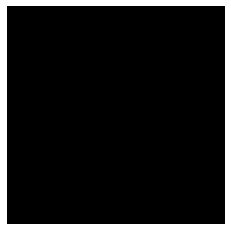

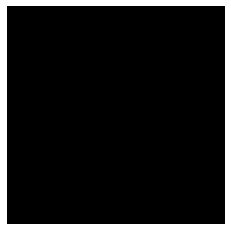

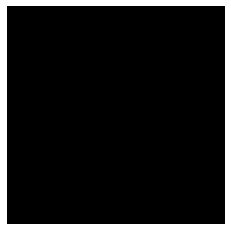

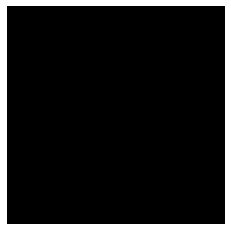

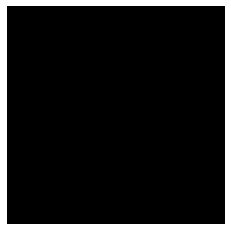

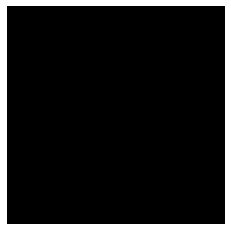

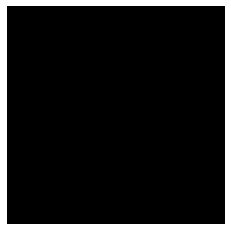

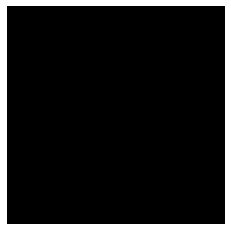

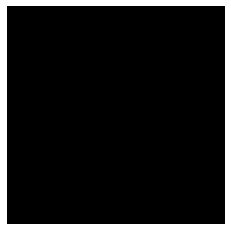

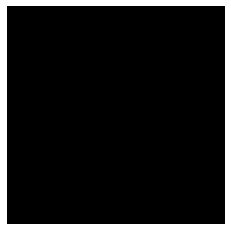

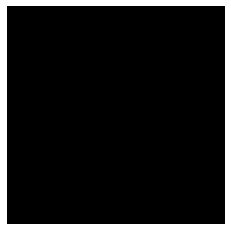

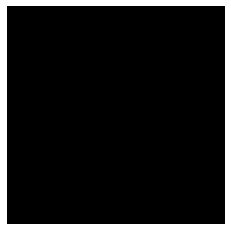

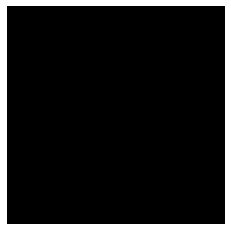

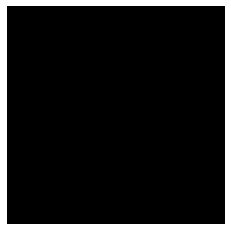

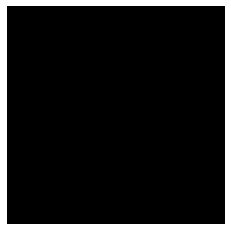

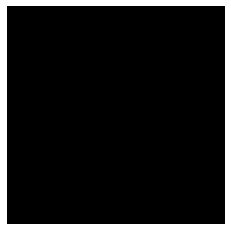

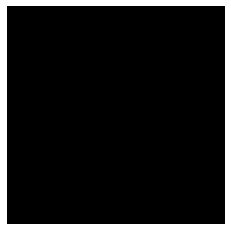

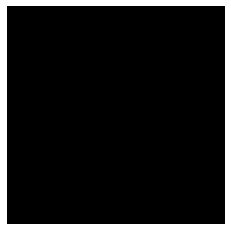

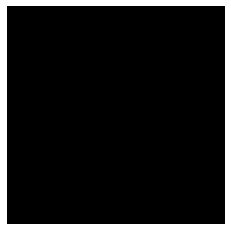

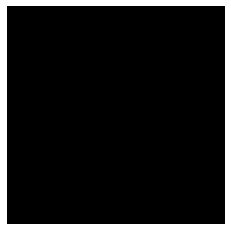

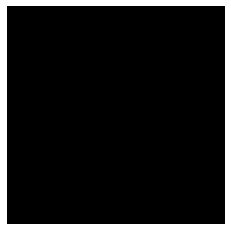

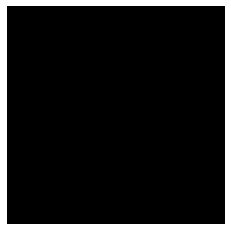

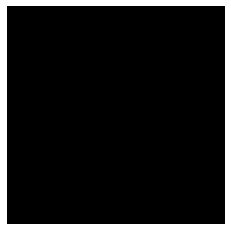

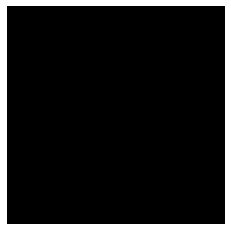

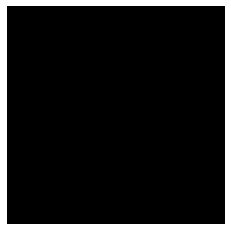

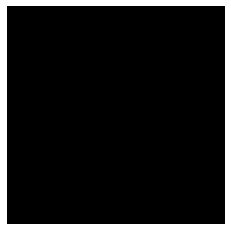

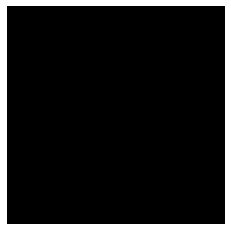

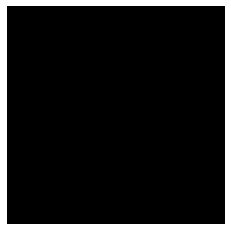

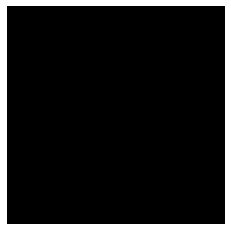

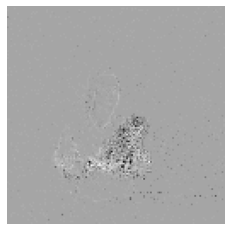

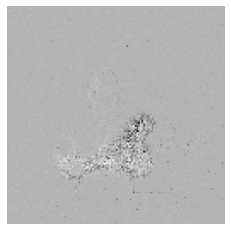

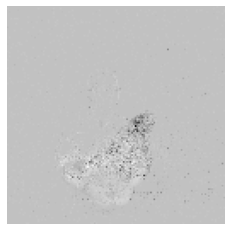

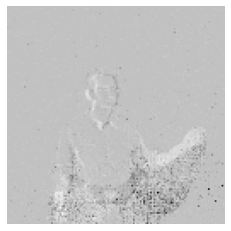

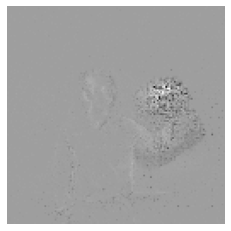

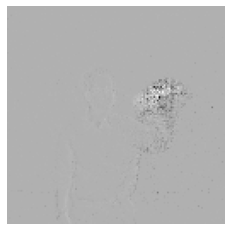

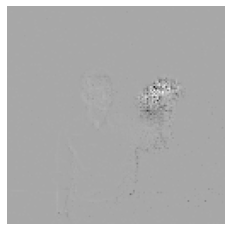

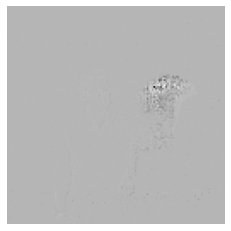

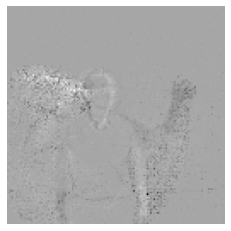

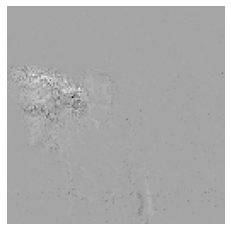

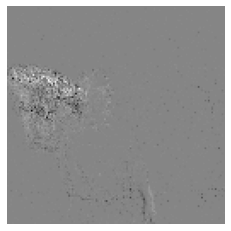

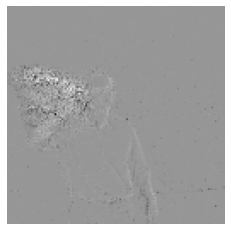

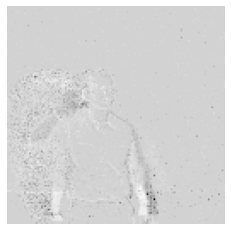

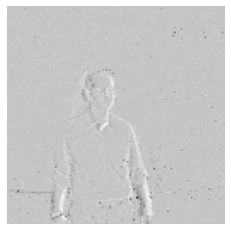

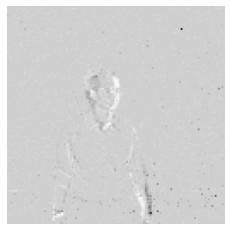

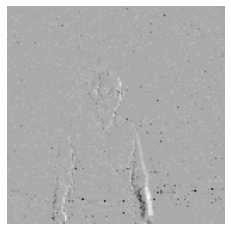

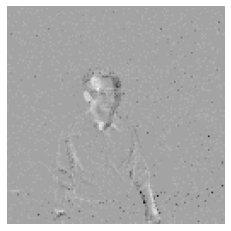

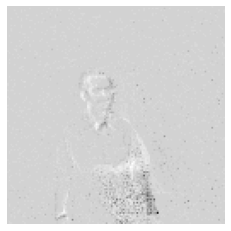

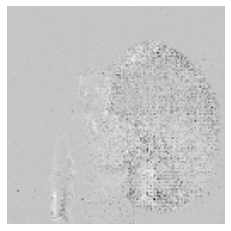

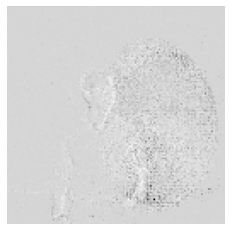

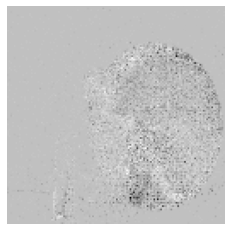

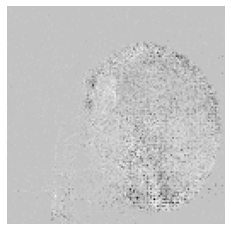

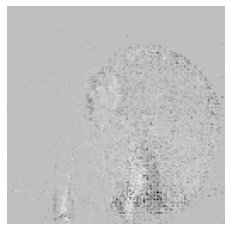

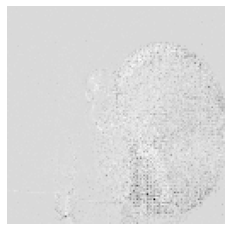

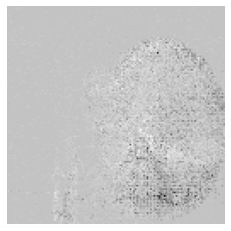

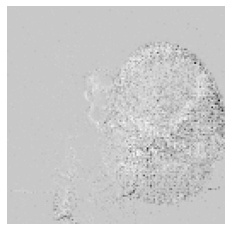

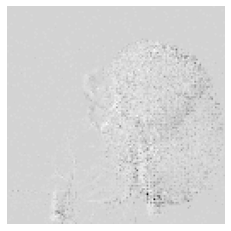

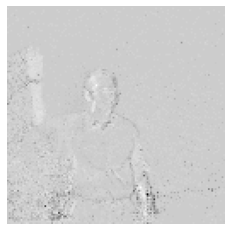

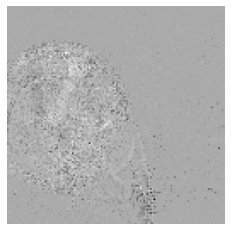

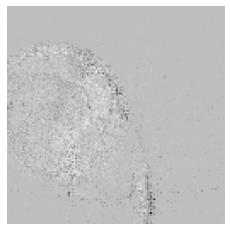

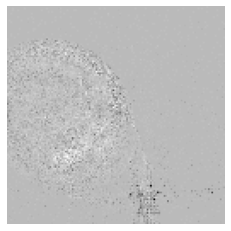

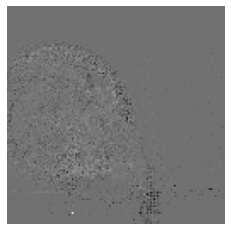

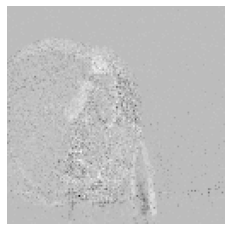

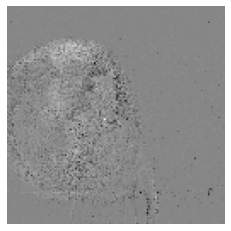

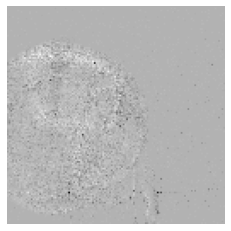

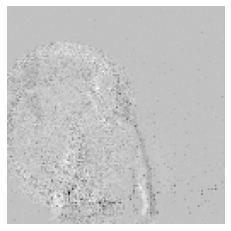

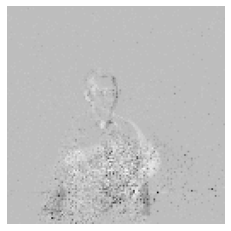

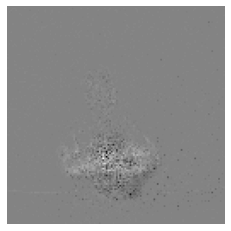

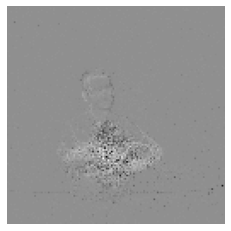

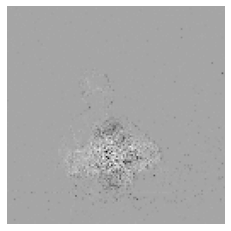

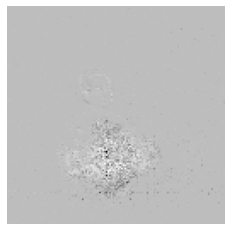

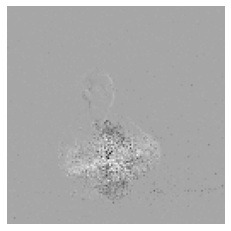

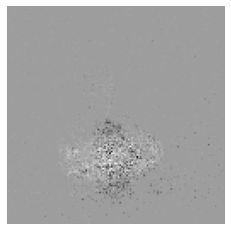

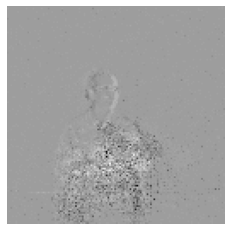

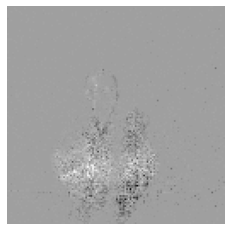

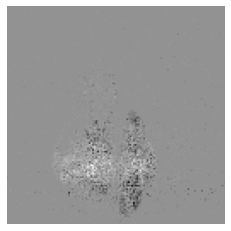

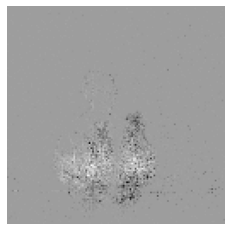

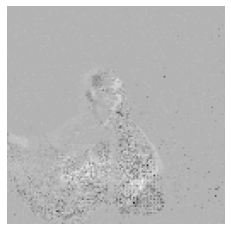

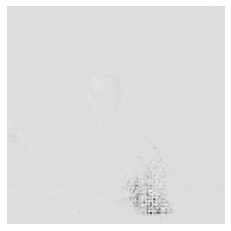

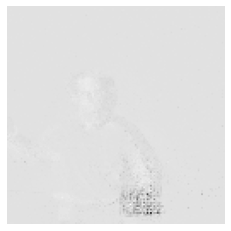

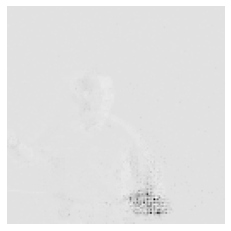

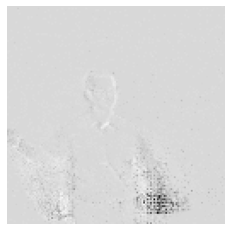

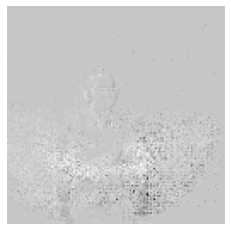

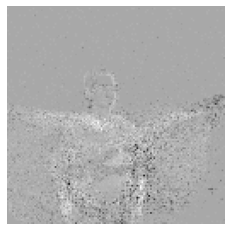

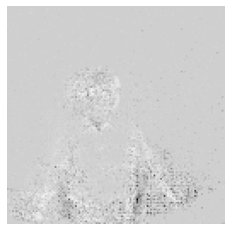

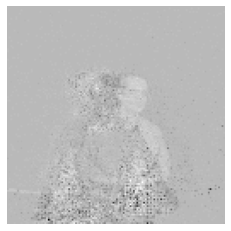

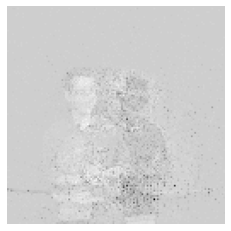

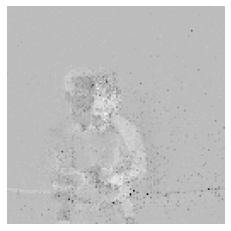

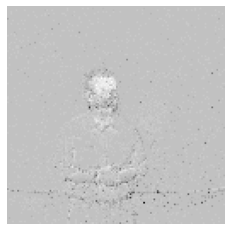

In [ ]:
import matplotlib.pyplot as plt
from scipy import ndimage

for frame in videos[0]:
  plt.imshow(ndimage.rotate(frame, -90), cmap='gray')
  plt.axis("off")
  plt.show()

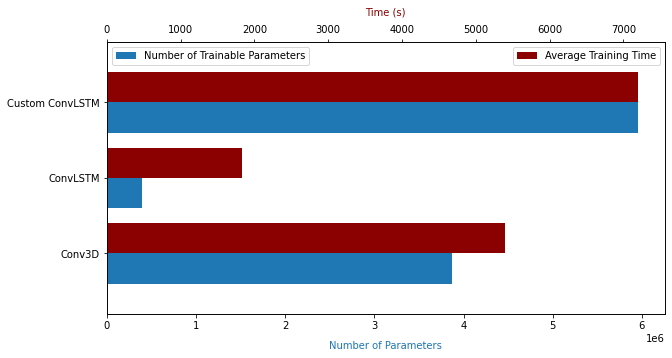

In [ ]:
import pandas
import matplotlib.pyplot as plt
import numpy as np

df = pandas.DataFrame(dict(graph=['Conv3D', 'ConvLSTM', 'Custom ConvLSTM'],
                           n=[3872426, 393898, 5959754], m=[5400, 1830, 7200]))

ind = np.arange(len(df))
width = 0.4

fig, ax = plt.subplots(figsize=(10, 5))

ax2 = ax.twiny()
ax.set_xlabel("Number of Parameters", labelpad=10)
ax.xaxis.label.set_color('#1f77b4')
ax.barh(ind, df.n, width, label='Number of Trainable Parameters')

ax2.set_xlabel("Time (s)", labelpad=10)
ax2.xaxis.label.set_color('darkred')
ax2.barh(ind + width, df.m, width, label='Average Training Time', color="darkred")

ax.set(yticks=ind + width/2, yticklabels=df.graph, ylim=[width - 1, len(df)])
ax.legend(loc='upper left')
ax2.legend()

plt.show()

# NMNIST

## Working with Data


### Helper Functions

In [ ]:
from typing import NamedTuple
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import seaborn as sns
import pandas as pd

class Event(NamedTuple):
    x_location: int
    y_location: int
    polarity: int
    timestamp: int

def read_events(filepath):
  file = open(filepath, "rb")

  events = []

  # reading 5 bytes (40 bits) at a time
  event = int.from_bytes(file.read(5), byteorder="little", signed=False)

  i = 0
  while event:
    # interpreting binary data
    location_mask = 0b11111111
    x_location = location_mask & event
    y_location = location_mask & (event>>8)
    polarity = 0b1 & (event>>16)
    timestamp_mask = 0b11111111111111111111111
    timestamp = timestamp_mask & (event>>17)

    # appending to list of events
    events.append(Event(x_location, y_location, polarity, timestamp))

    # reading next event
    event = int.from_bytes(file.read(5), byteorder="little", signed=False)
    i += 1

  file.close()
  return events

def visualise_events(event_list):
  off_events = list(filter(lambda event: event.polarity == 0, event_list))
  on_events = list(filter(lambda event: event.polarity == 1, event_list))

  fig = plt.figure(figsize=(8,8))
  ax = fig.add_subplot(111, projection='3d')
  ax.set_xlabel("x_location (pixels)")
  ax.set_ylabel("timestamp (ms)")
  ax.set_zlabel("y_location (pixels)")

  ax.scatter(
      [e.x_location for e in off_events],
      [e.timestamp for e in off_events],
      [e.y_location for e in off_events],
      c="blue",
      label="off events")

  ax.scatter(
      [e.x_location for e in on_events],
      [e.timestamp for e in on_events],
      [e.y_location for e in on_events],
      c="red",
      label="on events")

  ax.legend()
  plt.show()

def segment_events(event_list, segments, visualise):
  sorted_events = sorted(event_list, key=lambda e: e.timestamp, reverse=False)
  timestamp_range = sorted_events[-1].timestamp - sorted_events[0].timestamp
  if visualise:
    print("{0} -> {1} ms = {2} ms".format(sorted_events[0].timestamp, sorted_events[-1].timestamp, timestamp_range))

  segmented_events = []
  for i in range(segments):
    segmented_events.append(list(filter(
        lambda event: event.timestamp < (i+1)*(sorted_events[-1].timestamp/segments)
        and event.timestamp > (i)*(sorted_events[-1].timestamp/segments), events)))
    if i%3 == 1 and visualise == 1:
      visualise_events(segmented_events[-1])

  return segmented_events

def visualise_on_off_events(event_list):
  off_events = list(filter(lambda event: event.polarity == 0, event_list))
  on_events = list(filter(lambda event: event.polarity == 1, event_list))

  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
  ax1.set_xlabel("x_location (pixels)")
  ax1.set_ylabel("y_location (pixels)")
  ax2.set_xlabel("x_location (pixels)")
  ax2.set_ylabel("y_location (pixels)")

  ax1.set_title("On Events")

  ax1.scatter(
      [e.x_location for e in on_events],
      [e.y_location for e in on_events],
      c="red",
      label="on events")

  ax2.set_title("Off Events")

  ax2.scatter(
      [e.x_location for e in off_events],
      [e.y_location for e in off_events],
      c="blue",
      label="off events")

  ax1.grid()
  ax2.grid()

  plt.show()

def get_intensity(event_list, max_x, max_y):
  off_events = list(filter(lambda event: event.polarity == 0, event_list))
  on_events = list(filter(lambda event: event.polarity == 1, event_list))

  intensity_pos = [[0 for _ in range(max_x + 1)] for _ in range(max_y + 1)]
  intensity_neg = [[0 for _ in range(max_x + 1)] for _ in range(max_y + 1)]

  for e in on_events:
    intensity_pos[e.x_location][e.y_location] = 1

  for e in off_events:
    intensity_neg[e.x_location][e.y_location] = 1

  return np.array([intensity_pos, intensity_neg])


def visulaise_intensity_map(event_list, max_x, max_y):
  intensity = get_intensity(event_list, max_x, max_y)

  fig = plt.figure(figsize=(8,6))
  ax = fig.add_subplot(111)
  ax.set_xlabel("x_location (pixels)")
  ax.set_ylabel("y_location (pixels)")

  # Create a dataset
  df = pd.DataFrame(intensity)

  # Default heatmap
  ax = sns.heatmap(df)
  ax.invert_yaxis()
  # p1 = sns.heatmap(df)
  plt.show()

### Downloading Data

In [ ]:
# Loading N-MNIST dataset
import zipfile
!wget -O "MNIST_testing.zip" "https://data.mendeley.com/public-files/datasets/468j46mzdv/files/05a4d654-7e03-4c15-bdfa-9bb2bcbea494/file_downloaded"
with zipfile.ZipFile("MNIST_testing.zip", 'r') as zip_ref:
    zip_ref.extractall("/content/NMNIST")
!rm "MNIST_testing.zip"
!wget -O "MNIST_training.zip" "https://data.mendeley.com/public-files/datasets/468j46mzdv/files/39c25547-014b-4137-a934-9d29fa53c7a0/file_downloaded"
with zipfile.ZipFile("MNIST_training.zip", 'r') as zip_ref:
    zip_ref.extractall("/content/NMNIST")
!rm "MNIST_training.zip"

--2022-06-15 19:11:57--  https://data.mendeley.com/public-files/datasets/468j46mzdv/files/05a4d654-7e03-4c15-bdfa-9bb2bcbea494/file_downloaded
Resolving data.mendeley.com (data.mendeley.com)... 162.159.130.86, 162.159.133.86
Connecting to data.mendeley.com (data.mendeley.com)|162.159.130.86|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://md-datasets-public-files-prod.s3.eu-west-1.amazonaws.com/a99d0fee-a95b-4231-ad22-988fdb0a2411 [following]
--2022-06-15 19:11:58--  https://md-datasets-public-files-prod.s3.eu-west-1.amazonaws.com/a99d0fee-a95b-4231-ad22-988fdb0a2411
Resolving md-datasets-public-files-prod.s3.eu-west-1.amazonaws.com (md-datasets-public-files-prod.s3.eu-west-1.amazonaws.com)... 52.218.117.194
Connecting to md-datasets-public-files-prod.s3.eu-west-1.amazonaws.com (md-datasets-public-files-prod.s3.eu-west-1.amazonaws.com)|52.218.117.194|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 169674850 (162M) [applica

In [ ]:
# !cp -r /content/NMNIST /content/drive/MyDrive

Each example is a separate binary file consisting of a list of events. Each event occupies 40 bits as described below:

- bit 39 - 32: Xaddress (in pixels)

- bit 31 - 24: Yaddress (in pixels)

- bit 23: Polarity (0 for OFF, 1 for ON)

- bit 22 - 0: Timestamp (in microseconds)

### Preprocessing Data

In [ ]:
from keras.utils import np_utils
import os
import pickle

max_no = 10000/20

x_train = []
y_train = []
print('Loading training samples')
for act_class in range(10):
  # print(' class {0}'.format(act_class))
  # directory = "/content/drive/MyDrive/NMNIST/Train/{0}".format(act_class)
  directory = "/content/NMNIST/Train/{0}/".format(act_class)
  # iterate over files in
  # that directory
  count = 0
  for sample in os.listdir(directory):
      f = os.path.join(directory, sample)
      # checking if it is a file
      if os.path.isfile(f) and count < 6 * max_no:
          # print(f)
          events = read_events(f)
          max_x = 33
          max_y = 33
          segmented_events = segment_events(events, 8, False)
          intensity_maps = []
          for segment in segmented_events:
            intensity_maps.append(get_intensity(segment, max_x, max_y))
          x_train.append(intensity_maps)
          y_train.append(np_utils.to_categorical(act_class, 10))
      else:
        pass
      count = count + 1
  # print('   {0} samples loaded'.format(number_of_samples))

x_test = []
y_test = []
print('Loading testing samples')
for act_class in range(10):
  # print(' class {0}'.format(act_class))
  # directory = "/content/drive/MyDrive/NMNIST/Test/{0}".format(act_class)
  directory = "/content/NMNIST/Test/{0}/".format(act_class)
  # iterate over files in
  # that directory
  count = 0
  for sample in os.listdir(directory):
      f = os.path.join(directory, sample)
      # checking if it is a file
      if os.path.isfile(f) and count < max_no:
          # print(f)
          events = read_events(f)
          max_x = 33
          max_y = 33
          segmented_events = segment_events(events, 8, False)
          intensity_maps = []
          for segment in segmented_events:
            intensity_maps.append(get_intensity(segment, max_x, max_y))
          x_test.append(intensity_maps)
          y_test.append(np_utils.to_categorical(act_class, 10))
      else:
        pass
      count = count + 1
  # print('   {0} samples loaded'.format(number_of_samples))

x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)

Loading training samples
Loading testing samples


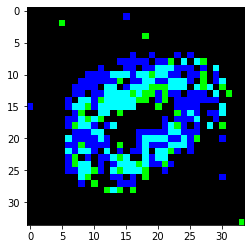

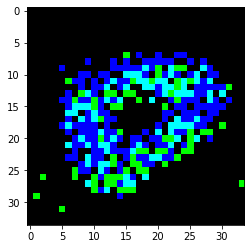

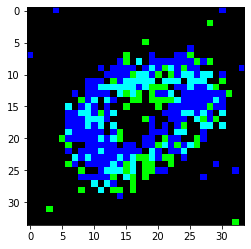

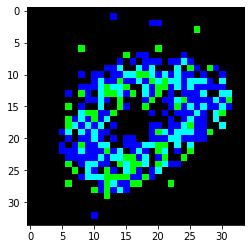

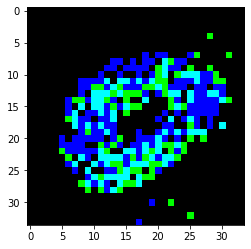

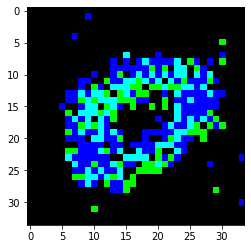

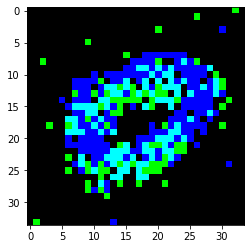

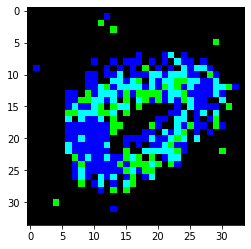

In [ ]:
import cv2

for i in range(len(x_train[0])):
  merged = np.array([np.zeros(shape=(34, 34)),x_train[0][i][0],x_train[0][i][1]])
  merged = np.moveaxis(merged, 0, -1)
  plt.imshow(merged)
  plt.show()

In [ ]:
x_train = np.moveaxis(x_train, -3, -1)
x_test = np.moveaxis(x_test, -3, -1)
train_events = {"x": x_train, "y": y_train}
test_events = {"x": x_test, "y": y_test}
all_events = {"train": train_events, "test": test_events}

In [ ]:
from sklearn.model_selection import train_test_split

train_set = x_train.astype('float32')
train_set -= np.mean(x_train)
train_set /= np.max(x_train)
test_set = x_test.astype('float32')
test_set -= np.mean(x_train)
test_set /= np.max(x_train)
x_train = train_set
x_test = test_set
del test_set
del train_set
del train_events
del test_events
del all_events

# Spliting the dataset for testing and training
x_train, x_val, y_train, y_val =  train_test_split(x_train, y_train, test_size=0.2, random_state=4)

print('Image shape: {0}'.format(x_train.shape[1:]))
print('Output shape: {0}'.format(y_train.shape))
print('Total number of training samples: {0}'.format(x_train.shape[0]))
print('Total number of validation samples: {0}'.format(x_val.shape[0]))
print('Total number of test samples: {0}'.format(x_test.shape[0]))

Image shape: (8, 34, 34, 2)
Output shape: (24000, 10)
Total number of training samples: 24000
Total number of validation samples: 6000
Total number of test samples: 5000


### Saving Data

In [ ]:
open_file = open("/content/drive/MyDrive/NMNIST/event_list_classic.pkl", "wb")
pickle.dump(all_events, open_file, protocol=4)
open_file.close()

### Loading Data

In [ ]:
import pickle
import numpy as np
from sklearn.model_selection import train_test_split

open_file = open("/content/drive/MyDrive/NMNIST/event_list_classic.pkl", "rb")
events = pickle.load(open_file)
open_file.close()

x_train = events["train"]["x"]
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], x_train.shape[3], 1)
train_set = x_train.astype('float32')
train_set -= np.mean(x_train)
train_set /= np.max(x_train)

x_test = events["test"]["x"]
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], x_test.shape[3], 1)
test_set = x_test.astype('float32')
test_set -= np.mean(x_train)
test_set /= np.max(x_train)

x_train = train_set
x_test = test_set
del test_set
del train_set

y_train = events["train"]["y"]
y_test = events["test"]["y"]

# Spliting the dataset for testing and training
x_train, x_val, y_train, y_val =  train_test_split(x_train, y_train, test_size=0.2, random_state=4)

print('Image shape: {0}'.format(x_train.shape[1:]))
print('Output shape: {0}'.format(y_train.shape))
print('Total number of training samples: {0}'.format(x_train.shape[0]))
print('Total number of validation samples: {0}'.format(x_val.shape[0]))
print('Total number of test samples: {0}'.format(x_test.shape[0]))

Image shape: (8, 34, 34, 1)
Output shape: (24000, 10)
Total number of training samples: 24000
Total number of validation samples: 6000
Total number of test samples: 5000


## Classification Networks

### Custom Conv3D Network

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution3D, MaxPooling3D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam
from keras.utils import np_utils
from keras.callbacks import TensorBoard, EarlyStopping
from sklearn.model_selection import train_test_split
import keras

# Initialing the Training Parameters
batch_size = 32
nb_classes = 10
nb_epoch = 120

# Number of convolutional filters to use at each layer
nb_filters = 32
# Level of pooling to perform at each layer (POOL x POOL)
nb_pool = 2
# Level of convolution to perform at each layer (CONV x CONV)
nb_conv = 5

# Defining the 3D Convolution Neural Network model
model = Sequential()
model.add(Convolution3D(nb_filters,kernel_size=nb_conv,input_shape=x_train.shape[1:], activation='relu',padding='same'))
model.add(BatchNormalization())
model.add(Convolution3D(nb_filters,kernel_size=nb_conv,input_shape=x_train.shape[1:], activation='relu',padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=nb_pool,padding='same'))

model.add(Dropout(0.25))

model.add(Convolution3D(nb_filters*2,kernel_size=nb_conv,activation='relu',padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=nb_pool,padding='same'))

model.add(Dropout(0.25))

model.add(Convolution3D(nb_filters*4,kernel_size=nb_conv,activation='relu',padding='same'))
model.add(BatchNormalization())
model.add(Convolution3D(nb_filters*4,kernel_size=nb_conv,activation='relu',padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=nb_pool,padding='same'))

model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128,kernel_initializer = 'he_normal',activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(nb_classes,kernel_initializer = 'he_normal'))
model.add(Activation('softmax'))

opt=Adam(lr=0.0001)

model.summary()

# Compile the model
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Spliting the dataset for testing and training
x_train_new, x_val_new, y_train_new, y_val_new =  train_test_split(x_train, y_train, test_size=0.2, random_state=4)

logdir = "logs/scalars/conv3d_nmnist"

# Training  the model along with creating callbacks to tensorboard for graphical visualization of training process
tbcallback = keras.callbacks.TensorBoard(log_dir=logdir, histogram_freq=0, write_graph=True, write_images=True)
early_stopping = EarlyStopping(monitor='val_accuracy', patience=4, restore_best_weights=True)
hist = model.fit(x_train_new, y_train_new, validation_data=(x_val_new,y_val_new),
          batch_size=batch_size,epochs = nb_epoch,shuffle=True,verbose=1,callbacks=[tbcallback, early_stopping])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 8, 34, 34, 32)     8032      
                                                                 
 batch_normalization (BatchN  (None, 8, 34, 34, 32)    128       
 ormalization)                                                   
                                                                 
 conv3d_1 (Conv3D)           (None, 8, 34, 34, 32)     128032    
                                                                 
 batch_normalization_1 (Batc  (None, 8, 34, 34, 32)    128       
 hNormalization)                                                 
                                                                 
 max_pooling3d (MaxPooling3D  (None, 4, 17, 17, 32)    0         
 )                                                               
                                                        

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


 max_pooling3d_1 (MaxPooling  (None, 2, 9, 9, 64)      0         
 3D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 2, 9, 9, 64)       0         
                                                                 
 conv3d_3 (Conv3D)           (None, 2, 9, 9, 128)      1024128   
                                                                 
 batch_normalization_3 (Batc  (None, 2, 9, 9, 128)     512       
 hNormalization)                                                 
                                                                 
 conv3d_4 (Conv3D)           (None, 2, 9, 9, 128)      2048128   
                                                                 
 batch_normalization_4 (Batc  (None, 2, 9, 9, 128)     512       
 hNormalization)                                                 
                                                                 
 max_pooli

In [ ]:
from keras.models import load_model

model.save('/content/drive/MyDrive/models/conv3d_nmnist_classic.h5')  # creates a HDF5 file 'my_model.h5'
# del model  # deletes the existing model

#### Results

In [ ]:
from keras.models import load_model

model = load_model('/content/drive/MyDrive/models/conv3d_nmnist_classic.h5')

In [ ]:
score = model.evaluate(x_test, y_test)
y_pred = model.predict(x_test)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

157/157 [==============================] - 4s 24ms/step - loss: 0.0407 - accuracy: 0.9874
Test loss: 0.040693506598472595
Test accuracy: 0.9873999953269958


In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1)))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99       500
           1       0.99      1.00      0.99       500
           2       0.99      0.99      0.99       500
           3       0.98      1.00      0.99       500
           4       0.99      0.99      0.99       500
           5       0.99      0.97      0.98       500
           6       0.99      0.99      0.99       500
           7       0.99      0.97      0.98       500
           8       0.97      0.99      0.98       500
           9       0.98      0.98      0.98       500

    accuracy                           0.99      5000
   macro avg       0.99      0.99      0.99      5000
weighted avg       0.99      0.99      0.99      5000



[Text(0, 0.5, '0'),
 Text(0, 1.5, '1'),
 Text(0, 2.5, '2'),
 Text(0, 3.5, '3'),
 Text(0, 4.5, '4'),
 Text(0, 5.5, '5'),
 Text(0, 6.5, '6'),
 Text(0, 7.5, '7'),
 Text(0, 8.5, '8'),
 Text(0, 9.5, '9')]

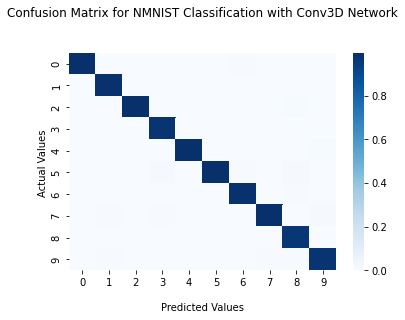

In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np
from keras.utils import np_utils
import seaborn as sns

#Create confusion matrix and normalizes it over predicted (columns)
result = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1), normalize='pred')

ax = sns.heatmap(result, annot=False, cmap='Blues')

ax.set_title('Confusion Matrix for NMNIST Classification with Conv3D Network\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels([i for i in range(10)])
ax.yaxis.set_ticklabels([i for i in range(10)])

### Conv2D LTSM Network

In [ ]:
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.callbacks import TensorBoard
import keras
from sklearn.model_selection import train_test_split

timesteps = 8
width = 34
height = 34
channels = 2
action_num = 10

model = models.Sequential(
    [
        layers.Input(
            shape=(timesteps, width, height, channels)
        ),
        layers.ConvLSTM2D(
            filters=64, kernel_size=(3, 3), padding="same", return_sequences=True, dropout=0.1, recurrent_dropout=0.1
        ),
        layers.MaxPool3D(
            pool_size=(1, 2, 2), strides=(1, 2, 2), padding="same"
        ),
        layers.BatchNormalization(),
        layers.ConvLSTM2D(
            filters=32, kernel_size=(3, 3), padding="same", return_sequences=True, dropout=0.1, recurrent_dropout=0.1
        ),
        layers.MaxPool3D(
            pool_size=(1, 2, 2), strides=(1, 2, 2), padding="same"
        ),
        layers.BatchNormalization(),
        layers.ConvLSTM2D(
            filters=16, kernel_size=(3, 3), padding="same", return_sequences=False, dropout=0.1, recurrent_dropout=0.1
        ),
        layers.MaxPool2D(
            pool_size=(2, 2), strides=(2, 2), padding="same"
        ),
        layers.BatchNormalization(),
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dense(action_num, activation='softmax')
    ]
)

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=1e-4),
              metrics=['accuracy'])

model.summary()

early_stopping = EarlyStopping(monitor='val_accuracy', patience=4, restore_best_weights=True)

history = model.fit(x_train, y_train, batch_size=32, epochs=40, validation_data=(x_val, y_val), callbacks=[early_stopping])

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d_6 (ConvLSTM2D)  (None, 8, 34, 34, 64)     152320    
                                                                 
 max_pooling3d_7 (MaxPooling  (None, 8, 17, 17, 64)    0         
 3D)                                                             
                                                                 
 batch_normalization_12 (Bat  (None, 8, 17, 17, 64)    256       
 chNormalization)                                                
                                                                 
 conv_lstm2d_7 (ConvLSTM2D)  (None, 8, 17, 17, 32)     110720    
                                                                 
 max_pooling3d_8 (MaxPooling  (None, 8, 9, 9, 32)      0         
 3D)                                                             
                                                      

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/40
750/750 [==============================] - 139s 173ms/step - loss: 0.5138 - accuracy: 0.8449 - val_loss: 0.2228 - val_accuracy: 0.9312
Epoch 2/40
750/750 [==============================] - 133s 177ms/step - loss: 0.1946 - accuracy: 0.9370 - val_loss: 0.1460 - val_accuracy: 0.9553
Epoch 3/40
750/750 [==============================] - 138s 184ms/step - loss: 0.1404 - accuracy: 0.9547 - val_loss: 0.1367 - val_accuracy: 0.9597
Epoch 4/40
750/750 [==============================] - 134s 179ms/step - loss: 0.1105 - accuracy: 0.9638 - val_loss: 0.1169 - val_accuracy: 0.9647
Epoch 5/40
750/750 [==============================] - 126s 169ms/step - loss: 0.0929 - accuracy: 0.9698 - val_loss: 0.0980 - val_accuracy: 0.9697
Epoch 6/40
750/750 [==============================] - 134s 179ms/step - loss: 0.0781 - accuracy: 0.9742 - val_loss: 0.0899 - val_accuracy: 0.9723
Epoch 7/40
750/750 [==============================] - 135s 180ms/step - loss: 0.0691 - accuracy: 0.9778 - val_loss: 0.0825 -

In [ ]:
from keras.models import load_model

model.save('/content/drive/MyDrive/models/conv_lstm_nmnist_classic.h5')  # creates a HDF5 file 'my_model.h5'
# del model  # deletes the existing model

#### Results

In [ ]:
from keras.models import load_model

model = load_model('/content/drive/MyDrive/models/conv_lstm_nmnist_classic.h5')

In [ ]:
score = model.evaluate(x_test, y_test)
y_pred = model.predict(x_test)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

157/157 [==============================] - 7s 45ms/step - loss: 0.0799 - accuracy: 0.9764
Test loss: 0.0798872709274292
Test accuracy: 0.9764000177383423


In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98       500
           1       0.99      0.99      0.99       500
           2       0.99      0.99      0.99       500
           3       0.99      0.96      0.97       500
           4       0.99      0.95      0.97       500
           5       0.97      0.98      0.98       500
           6       0.99      0.97      0.98       500
           7       0.97      0.98      0.97       500
           8       0.96      0.97      0.97       500
           9       0.94      0.98      0.96       500

    accuracy                           0.98      5000
   macro avg       0.98      0.98      0.98      5000
weighted avg       0.98      0.98      0.98      5000



[Text(0, 0.5, '0'),
 Text(0, 1.5, '1'),
 Text(0, 2.5, '2'),
 Text(0, 3.5, '3'),
 Text(0, 4.5, '4'),
 Text(0, 5.5, '5'),
 Text(0, 6.5, '6'),
 Text(0, 7.5, '7'),
 Text(0, 8.5, '8'),
 Text(0, 9.5, '9')]

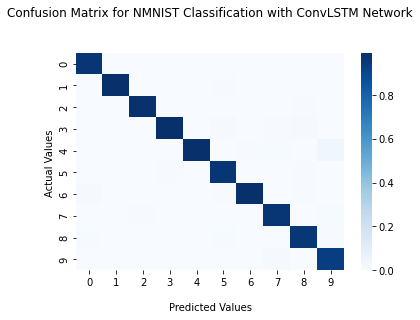

In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np
from keras.utils import np_utils
import seaborn as sns

#Create confusion matrix and normalizes it over predicted (columns)
result = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1), normalize='pred')

ax = sns.heatmap(result, annot=False, cmap='Blues')

ax.set_title('Confusion Matrix for NMNIST Classification with ConvLSTM Network\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels([i for i in range(10)])
ax.yaxis.set_ticklabels([i for i in range(10)])

### Custom LTSM Network 1

In [ ]:
from keras.layers import Conv2D, MaxPooling2D, Flatten

def build_convnet(shape=(34, 34, 1)):
  model = Sequential()
  model.add(Conv2D(128, (2,2), padding='same', input_shape=shape))
  model.add(Activation('relu'))

  model.add(MaxPooling2D(pool_size=(2,2)))

  model.add(Conv2D(256, (2,2), padding='same'))
  model.add(Activation('relu'))

  model.add(MaxPooling2D(pool_size=(2,2)))

  model.add(Conv2D(512, (2,2), padding='same'))
  model.add(Activation('relu'))

  model.add(MaxPooling2D(pool_size=(2,2)))

  model.add(Flatten())

  return model

In [ ]:
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from keras.layers import TimeDistributed, GRU

def action_model(shape=(8, 34, 34, 1), nbout=10):
    # Create our convnet with (34, 34, 1) input shape
    print("done")
    convnet = build_convnet(shape[1:])

    # then create our final model
    model = Sequential()
    # add the convnet with (8, 34, 34, 1) shape
    model.add(TimeDistributed(convnet, input_shape=shape))
    # here, you can also use GRU or LSTM
    model.add(GRU(64))
    # and finally, we make a decision network
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(.5))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(.5))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(nbout, activation='softmax'))
    return model

In [ ]:
from keras.callbacks import EarlyStopping
from keras.callbacks import TensorBoard
import keras
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam

model = action_model(x_train.shape[1:], 10)
opt = Adam(lr=0.0001, decay=1e-6)

model.summary()

model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_accuracy', patience=4, restore_best_weights=True)

history = model.fit(x_train, y_train, batch_size=32, epochs=60, validation_data=(x_val, y_val), callbacks=[early_stopping])

done
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 8, 8192)          657280    
 ibuted)                                                         
                                                                 
 gru (GRU)                   (None, 64)                1585536   
                                                                 
 dense_8 (Dense)             (None, 1024)              66560     
                                                                 
 dropout_4 (Dropout)         (None, 1024)              0         
                                                                 
 dense_9 (Dense)             (None, 512)               524800    
                                                                 
 dropout_5 (Dropout)         (None, 512)               0         
                                                 

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/60
750/750 [==============================] - 35s 42ms/step - loss: 1.3929 - accuracy: 0.4793 - val_loss: 0.4274 - val_accuracy: 0.8598
Epoch 2/60
750/750 [==============================] - 29s 39ms/step - loss: 0.4020 - accuracy: 0.8838 - val_loss: 0.2028 - val_accuracy: 0.9452
Epoch 3/60
750/750 [==============================] - 29s 39ms/step - loss: 0.2605 - accuracy: 0.9284 - val_loss: 0.1695 - val_accuracy: 0.9490
Epoch 4/60
750/750 [==============================] - 30s 40ms/step - loss: 0.1997 - accuracy: 0.9450 - val_loss: 0.1267 - val_accuracy: 0.9633
Epoch 5/60
750/750 [==============================] - 30s 40ms/step - loss: 0.1694 - accuracy: 0.9537 - val_loss: 0.1602 - val_accuracy: 0.9568
Epoch 6/60
750/750 [==============================] - 29s 39ms/step - loss: 0.1437 - accuracy: 0.9616 - val_loss: 0.1065 - val_accuracy: 0.9717
Epoch 7/60
750/750 [==============================] - 29s 39ms/step - loss: 0.1240 - accuracy: 0.9660 - val_loss: 0.1166 - val_accuracy:

In [ ]:
from keras.models import load_model

model.save('/content/drive/MyDrive/models/custom_conv_lstm_nmnist_classic.h5')  # creates a HDF5 file 'my_model.h5'
# del model  # deletes the existing model

#### Results

In [ ]:
from keras.models import load_model

model = load_model('/content/drive/MyDrive/models/custom_conv_lstm_nmnist.h5')

In [ ]:
score = model.evaluate(x_test, y_test, verbose=0)
y_pred = model.predict(x_test)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.09929852932691574
Test accuracy: 0.9769999980926514


In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       500
           1       0.98      0.99      0.99       500
           2       0.99      0.97      0.98       500
           3       0.99      0.96      0.97       500
           4       0.99      0.98      0.98       500
           5       0.98      0.97      0.97       500
           6       0.98      0.99      0.98       500
           7       0.96      0.99      0.98       500
           8       0.94      0.97      0.95       500
           9       0.98      0.96      0.97       500

    accuracy                           0.98      5000
   macro avg       0.98      0.98      0.98      5000
weighted avg       0.98      0.98      0.98      5000



[Text(0, 0.5, '0'),
 Text(0, 1.5, '1'),
 Text(0, 2.5, '2'),
 Text(0, 3.5, '3'),
 Text(0, 4.5, '4'),
 Text(0, 5.5, '5'),
 Text(0, 6.5, '6'),
 Text(0, 7.5, '7'),
 Text(0, 8.5, '8'),
 Text(0, 9.5, '9')]

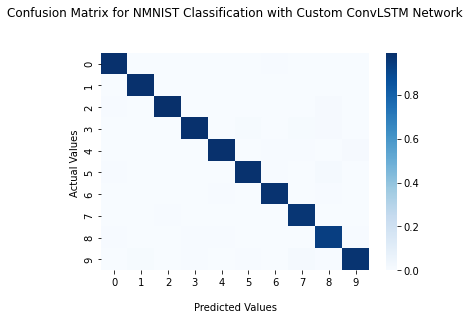

In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np
from keras.utils import np_utils
import seaborn as sns

#Create confusion matrix and normalizes it over predicted (columns)
result = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1), normalize='pred')

ax = sns.heatmap(result, annot=False, cmap='Blues')

ax.set_title('Confusion Matrix for NMNIST Classification with Custom ConvLSTM Network\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels([i for i in range(10)])
ax.yaxis.set_ticklabels([i for i in range(10)])

# DVS128 Gesture

In [ ]:
!rm -rf /content/datasets
!mkdir /content/datasets
!mkdir /content/datasets/DVS128Gesture
!unzip -q /content/drive/MyDrive/DVS128Gesture/'DVS  Gesture dataset.zip' -d /content/datasets/DVS128Gesture
!mv /content/datasets/DVS128Gesture/'DVS  Gesture dataset' /content/datasets/DVS128Gesture/download

unzip:  cannot find or open /content/drive/MyDrive/DVS128Gesture/DVS  Gesture dataset.zip, /content/drive/MyDrive/DVS128Gesture/DVS  Gesture dataset.zip.zip or /content/drive/MyDrive/DVS128Gesture/DVS  Gesture dataset.zip.ZIP.
mv: cannot stat '/content/datasets/DVS128Gesture/DVS  Gesture dataset': No such file or directory


In [ ]:
!pip -q install spikingjelly
from spikingjelly.datasets.dvs128_gesture import DVS128Gesture

root_dir = "/content/datasets/DVS128Gesture"
train_set = DVS128Gesture(root_dir, train=True, data_type='event')
test_set = DVS128Gesture(root_dir, train=False, data_type='event')

The [/content/datasets/DVS128Gesture/download] directory for saving downloaded files already exists, check files...
Mkdir [/content/datasets/DVS128Gesture/extract].
Extract [/content/datasets/DVS128Gesture/download/DvsGesture.tar.gz] to [/content/datasets/DVS128Gesture/extract].
Mkdir [/content/datasets/DVS128Gesture/events_np].
Start to convert the origin data from [/content/datasets/DVS128Gesture/extract] to [/content/datasets/DVS128Gesture/events_np] in np.ndarray format.
Mkdir [('/content/datasets/DVS128Gesture/events_np/train', '/content/datasets/DVS128Gesture/events_np/test').
Mkdir ['1', '9', '3', '5', '7', '4', '0', '8', '6', '10', '2'] in [/content/datasets/DVS128Gesture/events_np/train] and ['1', '9', '3', '5', '7', '4', '0', '8', '6', '10', '2'] in [/content/datasets/DVS128Gesture/events_np/test].
Start the ThreadPoolExecutor with max workers = [2].
Start to split [/content/datasets/DVS128Gesture/extract/DvsGesture/user01_fluorescent.aedat] to samples.
[/content/datasets/DVS

In [ ]:
!pip3 install -q dv
from dv import LegacyAedatFile
import os
import shutil
from typing import NamedTuple

class Event(NamedTuple):
    x_location: int
    y_location: int
    polarity: int
    timestamp: int

def restructure_spikingjelly_events(input_file):
  d = np.load(input_file)
  d = np.array([d["t"], d["x"], d["y"], d["p"]])
  p = []
  for i in range(len(d[0])):
    p.append(d[:, i])
  events = []
  for item in p:
    events.append(Event(item[1], item[2], item[3], item[0]))
  return events

def segment_events(event_list, segments, visualise):
  sorted_events = sorted(event_list, key=lambda e: e.timestamp, reverse=False)
  timestamp_range = sorted_events[-1].timestamp - sorted_events[0].timestamp
  start = sorted_events[0].timestamp

  segmented_events = []
  for i in range(segments):
    segmented_events.append(list(filter(
        lambda event: event.timestamp < start + (i+1)*(timestamp_range/segments)
        and event.timestamp > start + (i)*(timestamp_range/segments), event_list)))

  return segmented_events

def get_intensity(event_list, max_x, max_y):
  off_events = list(filter(lambda event: event.polarity == 0, event_list))
  on_events = list(filter(lambda event: event.polarity == 1, event_list))

  intensity = [[0 for _ in range(max_x)] for _ in range(max_y)]

  for e in on_events:
    intensity[e.x_location][e.y_location] += 1

  for e in off_events:
    intensity[e.x_location][e.y_location] -= 1
  return intensity

def custom_integrate_function(events, H, W):
    events = restructure_spikingjelly_events(events)
    segmented_events = segment_events(events, 20, False)
    intensity_maps = []
    for segment in segmented_events:
      intensity_maps.append(get_intensity(segment, H, W))
    return intensity_maps

     |████████████████████████████████| 1.2 MB 8.0 MB/s 
     |████████████████████████████████| 1.7 MB 50.4 MB/s 


In [ ]:
# !pip -q install spikingjelly
# from spikingjelly.datasets.cifar10_dvs import CIFAR10DVS
# import numpy as np

# root_dir = "/content/datasets/DVS128Gesture"
# train_set = DVS128Gesture(root_dir, train=True, data_type='frame', custom_integrate_function=custom_integrate_function)
# test_set = DVS128Gesture(root_dir, train=False, data_type='frame', custom_integrate_function=custom_integrate_function)

In [ ]:
from keras.utils import np_utils
import numpy as np
from sklearn.model_selection import train_test_split

import os
import shutil

max_samples = 50

def load_dvs_gesture_samples(train):
  print("Loading {0} samples".format("training" if train else "testing"))
  folder = "train" if train else "test"
  frame_sets = []
  labels = []
  for act_class in range(11):
    print(' class {0}'.format(act_class))
    directory = "/content/datasets/DVS128Gesture/events_np/{0}/{1}/".format(folder, act_class)
    count = 0
    for sample in os.listdir(directory):
        input_directory = os.path.join(directory, sample)
        if os.path.isfile(input_directory) and count < (max_samples if train else max_samples /4):
            if(count % 60 != 0 or count == 0):
              print(".", end="")
            else:
              print(".")

            events = restructure_spikingjelly_events(input_directory)
            segmented_events = segment_events(events, 20, False)
            intensity_maps = []
            for segment in segmented_events:
              intensity_maps.append(get_intensity(segment, 128, 128))
            frame_sets.append(intensity_maps)
            labels.append(np_utils.to_categorical(act_class, 11))
            # frame_sets.append(input_directory)
            # labels.append(act_class)

        count = count + 1
    print("")
  return np.array(frame_sets), np.array(labels)

training_files, training_labels = load_dvs_gesture_samples(train=True)
testing_files, testing_labels = load_dvs_gesture_samples(train=False)

training_files, validation_files, training_labels, validation_labels = train_test_split(training_files, training_labels, test_size=0.2, random_state=4)

Loading training samples
 class 0
..................................................
 class 1
..................................................
 class 2
..................................................
 class 3
..................................................
 class 4
..................................................
 class 5
..................................................
 class 6
..................................................
 class 7
..................................................
 class 8
..................................................
 class 9
..................................................
 class 10
..................................................
Loading testing samples
 class 0
.............
 class 1
.............
 class 2
.............
 class 3
.............
 class 4
.............
 class 5
.............
 class 6
.............
 class 7
.............
 class 8
.............
 class 9
.............
 class 10
.............


In [ ]:
import pickle

all_events = {"x_train": training_files, "x_val": validation_files, "x_test": testing_files,
          "y_train": training_labels, "y_val": validation_labels, "y_test": testing_labels}

!mkdir /content/DVS128Gesture
open_file = open("/content/DVS128Gesture/event_list.pkl", "wb")
pickle.dump(all_events, open_file, protocol=4)
open_file.close()

In [ ]:
!zip /content/DVS128Gesture /content/DVS128Gesture/event_list.pkl

  adding: content/DVS128Gesture/event_list.pkl (deflated 97%)


In [ ]:
x_train = all_events["x_train"]
x_val = all_events["x_val"]
x_test = all_events["x_test"]
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], x_train.shape[3], 1)
x_val = x_val.reshape(x_val.shape[0], x_val.shape[1], x_val.shape[2], x_val.shape[3], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], x_test.shape[3], 1)

y_train = all_events["y_train"]
y_val = all_events["y_val"]
y_test = all_events["y_test"]
print(x_train.shape)
print(x_val.shape)
print(x_test.shape)
print(y_train.shape)

(440, 20, 128, 128, 1)
(110, 20, 128, 128, 1)
(143, 20, 128, 128, 1)
(440, 11)


In [ ]:
train_set = x_train.astype('float32')
train_set -= np.mean(x_train)
train_set /= np.max(x_train)
val_set = x_val.astype('float32')
val_set -= np.mean(x_train)
val_set /= np.max(x_train)
test_set = x_test.astype('float32')
test_set -= np.mean(x_train)
test_set /= np.max(x_train)
x_train = train_set
x_val = val_set
x_test = test_set
del train_set
del test_set
del val_set

### Conv3D Network

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution3D, MaxPooling3D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam
from keras.utils import np_utils
from keras.callbacks import TensorBoard, EarlyStopping
from sklearn.model_selection import train_test_split
import keras
import datetime

# Initialing the Training Parameters
batch_size =3
nb_classes = 11
nb_epoch = 120

# Number of convolutional filters to use at each layer
nb_filters = 32
# Level of pooling to perform at each layer (POOL x POOL)
nb_pool = 3
# Level of convolution to perform at each layer (CONV x CONV)
nb_conv = 5

# Defining the 3D Convolution Neural Network model
model = Sequential()
model.add(Convolution3D(nb_filters,kernel_size=nb_conv,input_shape=x_train.shape[1:], activation='relu',padding='same'))
model.add(BatchNormalization())
model.add(Convolution3D(nb_filters,kernel_size=nb_conv,input_shape=x_train.shape[1:], activation='relu',padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=nb_pool,padding='same'))

model.add(Dropout(0.25))

model.add(Convolution3D(nb_filters*2,kernel_size=nb_conv,activation='relu',padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=nb_pool,padding='same'))

model.add(Dropout(0.25))

model.add(Convolution3D(nb_filters*4,kernel_size=nb_conv,activation='relu',padding='same'))
model.add(BatchNormalization())
model.add(Convolution3D(nb_filters*4,kernel_size=nb_conv,activation='relu',padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=nb_pool,padding='same'))

model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128,kernel_initializer = 'he_normal',activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(nb_classes,kernel_initializer = 'he_normal'))
model.add(Activation('softmax'))

opt=Adam(lr=0.0001)

# Compile the model
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_accuracy', patience=4, restore_best_weights=True)

hist = model.fit(x_train, y_train, validation_data=(x_val, y_val),
          batch_size=batch_size,epochs = nb_epoch,shuffle=True,verbose=1,callbacks=[early_stopping])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/120
147/147 [==============================] - 53s 269ms/step - loss: 2.8533 - accuracy: 0.1705 - val_loss: 2.8290 - val_accuracy: 0.0636
Epoch 2/120
147/147 [==============================] - 38s 259ms/step - loss: 2.2928 - accuracy: 0.2818 - val_loss: 3.6456 - val_accuracy: 0.1182
Epoch 3/120
147/147 [==============================] - 38s 261ms/step - loss: 2.3256 - accuracy: 0.2523 - val_loss: 3.6616 - val_accuracy: 0.1091
Epoch 4/120
147/147 [==============================] - 38s 260ms/step - loss: 2.0913 - accuracy: 0.3273 - val_loss: 2.9247 - val_accuracy: 0.1818
Epoch 5/120
147/147 [==============================] - 38s 260ms/step - loss: 2.0789 - accuracy: 0.3045 - val_loss: 1.6570 - val_accuracy: 0.3636
Epoch 6/120
147/147 [==============================] - 38s 260ms/step - loss: 1.9292 - accuracy: 0.3432 - val_loss: 1.3384 - val_accuracy: 0.5545
Epoch 7/120
147/147 [==============================] - 38s 259ms/step - loss: 1.8419 - accuracy: 0.3682 - val_loss: 1.2773 -

In [ ]:
from keras.models import load_model

model.save('/content/drive/MyDrive/models/conv3d_dvs128_custom.h5')  # creates a HDF5 file 'my_model.h5'
# del model  # deletes the existing model

#### Results

In [ ]:
from keras.models import load_model

model = load_model('/content/drive/MyDrive/models/conv3d_dvs128_custom.h5')

In [ ]:
score = model.evaluate(x_test, y_test, verbose=0)
y_pred = model.predict(x_test)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 1.002158761024475
Test accuracy: 0.6013985872268677


In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.40      0.92      0.56        13
           1       0.85      0.85      0.85        13
           2       0.92      0.85      0.88        13
           3       0.56      0.38      0.45        13
           4       0.67      0.31      0.42        13
           5       0.50      0.08      0.13        13
           6       0.55      0.92      0.69        13
           7       0.80      0.31      0.44        13
           8       0.67      0.46      0.55        13
           9       0.78      0.54      0.64        13
          10       0.50      1.00      0.67        13

    accuracy                           0.60       143
   macro avg       0.65      0.60      0.57       143
weighted avg       0.65      0.60      0.57       143



[Text(0, 0.5, '0'),
 Text(0, 1.5, '1'),
 Text(0, 2.5, '2'),
 Text(0, 3.5, '3'),
 Text(0, 4.5, '4'),
 Text(0, 5.5, '5'),
 Text(0, 6.5, '6'),
 Text(0, 7.5, '7'),
 Text(0, 8.5, '8'),
 Text(0, 9.5, '9'),
 Text(0, 10.5, '10')]

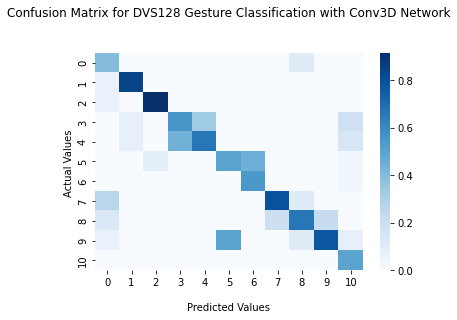

In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np
from keras.utils import np_utils
import seaborn as sns

#Create confusion matrix and normalizes it over predicted (columns)
result = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1), normalize='pred')

ax = sns.heatmap(result, annot=False, cmap='Blues')

ax.set_title('Confusion Matrix for DVS128 Gesture Classification with Conv3D Network\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels([i for i in range(12)])
ax.yaxis.set_ticklabels([i for i in range(12)])

### Conv LTSM Network

In [ ]:
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
import keras
from keras.callbacks import TensorBoard
from sklearn.model_selection import train_test_split

timesteps = 20
width = 128
height = 128
channels = 1
action_num = 11
nb_classes = 11

model = models.Sequential(
    [
        layers.Input(
            shape=(timesteps, width, height, channels)
        ),
        layers.ConvLSTM2D(
            filters=64, kernel_size=(3, 3), padding="same", return_sequences=True, dropout=0.1, recurrent_dropout=0.1
        ),
        layers.MaxPool3D(
            pool_size=(1, 2, 2), strides=(1, 2, 2), padding="same"
        ),
        layers.BatchNormalization(),
        layers.ConvLSTM2D(
            filters=32, kernel_size=(3, 3), padding="same", return_sequences=True, dropout=0.1, recurrent_dropout=0.1
        ),
        layers.MaxPool3D(
            pool_size=(1, 2, 2), strides=(1, 2, 2), padding="same"
        ),
        layers.BatchNormalization(),
        layers.ConvLSTM2D(
            filters=16, kernel_size=(3, 3), padding="same", return_sequences=False, dropout=0.1, recurrent_dropout=0.1
        ),
        layers.MaxPool2D(
            pool_size=(2, 2), strides=(2, 2), padding="same"
        ),
        layers.BatchNormalization(),
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dense(action_num, activation='softmax')
    ]
)

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=1e-4),
              metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_accuracy', patience=4, restore_best_weights=True)

model.fit(x_train, y_train, batch_size=4, epochs=60, validation_data=(x_val, y_val), callbacks=[early_stopping])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/60
110/110 [==============================] - 65s 532ms/step - loss: 1.5916 - accuracy: 0.4295 - val_loss: 2.4689 - val_accuracy: 0.1182
Epoch 2/60
110/110 [==============================] - 57s 523ms/step - loss: 0.7785 - accuracy: 0.7136 - val_loss: 2.6863 - val_accuracy: 0.0727
Epoch 3/60
110/110 [==============================] - 57s 522ms/step - loss: 0.5542 - accuracy: 0.8045 - val_loss: 2.4467 - val_accuracy: 0.1182
Epoch 4/60
110/110 [==============================] - 58s 523ms/step - loss: 0.3846 - accuracy: 0.8614 - val_loss: 2.0412 - val_accuracy: 0.2727
Epoch 5/60
110/110 [==============================] - 58s 527ms/step - loss: 0.2630 - accuracy: 0.9068 - val_loss: 1.6547 - val_accuracy: 0.4182
Epoch 6/60
110/110 [==============================] - 57s 523ms/step - loss: 0.1391 - accuracy: 0.9705 - val_loss: 1.3895 - val_accuracy: 0.6182
Epoch 7/60
110/110 [==============================] - 58s 527ms/step - loss: 0.1121 - accuracy: 0.9659 - val_loss: 0.8280 - val_ac

In [ ]:
from keras.models import load_model

model.save('/content/drive/MyDrive/models/conv_lstm_dvs128_custom.h5')  # creates a HDF5 file 'my_model.h5'
# del model  # deletes the existing model

#### Results

In [ ]:
from keras.models import load_model
model = load_model('/content/drive/MyDrive/models/conv_lstm_dvs128_custom.h5')

In [ ]:
from keras.utils import np_utils

score = model.evaluate(x_val, y_val, verbose=0, batch_size=8)
y_pred = model.predict(x_test, batch_size=8)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.5999184846878052
Test accuracy: 0.7727272510528564


In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.71      0.77      0.74        13
           1       1.00      0.92      0.96        13
           2       1.00      0.92      0.96        13
           3       0.59      0.77      0.67        13
           4       0.80      0.62      0.70        13
           5       0.75      0.92      0.83        13
           6       0.91      0.77      0.83        13
           7       0.82      0.69      0.75        13
           8       0.67      0.77      0.71        13
           9       0.90      0.69      0.78        13
          10       0.73      0.85      0.79        13

    accuracy                           0.79       143
   macro avg       0.81      0.79      0.79       143
weighted avg       0.81      0.79      0.79       143



[Text(0, 0.5, '0'),
 Text(0, 1.5, '1'),
 Text(0, 2.5, '2'),
 Text(0, 3.5, '3'),
 Text(0, 4.5, '4'),
 Text(0, 5.5, '5'),
 Text(0, 6.5, '6'),
 Text(0, 7.5, '7'),
 Text(0, 8.5, '8'),
 Text(0, 9.5, '9'),
 Text(0, 10.5, '10')]

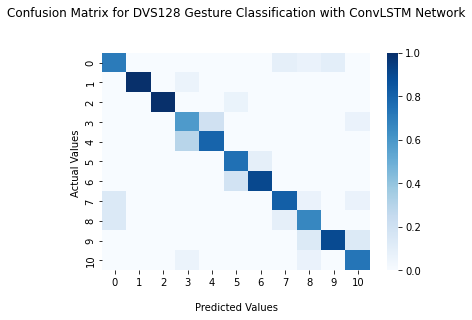

In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np
from keras.utils import np_utils
import seaborn as sns

#Create confusion matrix and normalizes it over predicted (columns)
result = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1), normalize='pred')

ax = sns.heatmap(result, annot=False, cmap='Blues')

ax.set_title('Confusion Matrix for DVS128 Gesture Classification with ConvLSTM Network\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels([i for i in range(12)])
ax.yaxis.set_ticklabels([i for i in range(12)])

### Custom LTSM Network 1

In [ ]:
from keras.layers import Conv2D, MaxPooling2D, Flatten

def build_convnet(shape=(128, 128, 2)):
  model = Sequential()
  model.add(Conv2D(128, (3,3), padding='same', input_shape=shape))
  model.add(Activation('relu'))

  model.add(MaxPooling2D(pool_size=(2,2)))

  model.add(Conv2D(64, (5,5), padding='same'))
  model.add(Activation('relu'))

  model.add(MaxPooling2D(pool_size=(2,2)))

  model.add(Conv2D(32, (7,7), padding='same'))
  model.add(Activation('relu'))

  model.add(MaxPooling2D(pool_size=(2,2)))

  model.add(Flatten())

  return model

In [ ]:
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from keras.layers import TimeDistributed, GRU

def action_model(shape=(20, 128, 128, 2), nbout=12):
    # Create our convnet with (34, 34, 1) input shape
    print("done")
    convnet = build_convnet(shape[1:])

    # then create our final model
    model = Sequential()
    # add the convnet with (8, 34, 34, 1) shape
    model.add(TimeDistributed(convnet, input_shape=shape))
    # here, you can also use GRU or LSTM
    model.add(GRU(64))
    # and finally, we make a decision network
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(.5))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(.5))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(nbout, activation='softmax'))
    return model

In [ ]:
from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

batch_size = 8
nb_epoch = 120

model = action_model((20, 128, 128, 1), 11)
opt = Adam(lr=0.0001, decay=1e-6)

model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_accuracy', patience=8, restore_best_weights=True)

model.fit(x_train, y_train, batch_size=4, epochs=60, validation_data=(x_val, y_val), callbacks=[early_stopping])

done


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/60
110/110 [==============================] - 11s 78ms/step - loss: 2.3983 - accuracy: 0.0932 - val_loss: 2.3942 - val_accuracy: 0.1727
Epoch 2/60
110/110 [==============================] - 8s 71ms/step - loss: 2.3373 - accuracy: 0.1386 - val_loss: 2.1078 - val_accuracy: 0.3545
Epoch 3/60
110/110 [==============================] - 8s 71ms/step - loss: 1.9925 - accuracy: 0.2636 - val_loss: 1.6623 - val_accuracy: 0.4091
Epoch 4/60
110/110 [==============================] - 8s 70ms/step - loss: 1.7538 - accuracy: 0.3318 - val_loss: 1.3738 - val_accuracy: 0.5091
Epoch 5/60
110/110 [==============================] - 8s 70ms/step - loss: 1.5103 - accuracy: 0.4250 - val_loss: 1.1770 - val_accuracy: 0.5364
Epoch 6/60
110/110 [==============================] - 8s 70ms/step - loss: 1.3925 - accuracy: 0.4455 - val_loss: 1.0415 - val_accuracy: 0.6364
Epoch 7/60
110/110 [==============================] - 8s 71ms/step - loss: 1.2594 - accuracy: 0.5250 - val_loss: 0.9696 - val_accuracy: 0.627

In [ ]:
from keras.models import load_model

model.save('/content/drive/MyDrive/models/custom_conv_lstm_dvs128_custom.h5')  # creates a HDF5 file 'my_model.h5'
# del model  # deletes the existing model

#### Results

In [ ]:
from keras.models import load_model
model = load_model('/content/drive/MyDrive/models/custom_conv_lstm_dvs128.h5')

In [ ]:
from keras.utils import np_utils

score = model.evaluate(x_val, y_val, verbose=0, batch_size=8)
y_pred = model.predict(x_test, batch_size=8)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.5994707345962524
Test accuracy: 0.8727272748947144


In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.61      0.85      0.71        13
           1       0.87      1.00      0.93        13
           2       0.89      0.62      0.73        13
           3       0.53      0.62      0.57        13
           4       0.78      0.54      0.64        13
           5       0.50      0.46      0.48        13
           6       0.47      0.62      0.53        13
           7       0.80      0.62      0.70        13
           8       0.90      0.69      0.78        13
           9       0.85      0.85      0.85        13
          10       0.60      0.69      0.64        13

    accuracy                           0.69       143
   macro avg       0.71      0.69      0.69       143
weighted avg       0.71      0.69      0.69       143



[Text(0, 0.5, '0'),
 Text(0, 1.5, '1'),
 Text(0, 2.5, '2'),
 Text(0, 3.5, '3'),
 Text(0, 4.5, '4'),
 Text(0, 5.5, '5'),
 Text(0, 6.5, '6'),
 Text(0, 7.5, '7'),
 Text(0, 8.5, '8'),
 Text(0, 9.5, '9'),
 Text(0, 10.5, '10')]

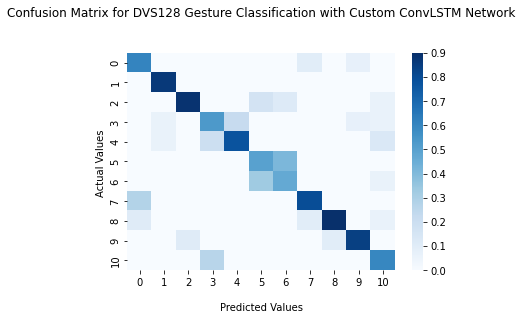

In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np
from keras.utils import np_utils
import seaborn as sns

#Create confusion matrix and normalizes it over predicted (columns)
result = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1), normalize='pred')

ax = sns.heatmap(result, annot=False, cmap='Blues')

ax.set_title('Confusion Matrix for DVS128 Gesture Classification with Custom ConvLSTM Network\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels([i for i in range(12)])
ax.yaxis.set_ticklabels([i for i in range(12)])

#CIFAR10 DVS

In [ ]:
!pip3 install -q dv
from dv import LegacyAedatFile
import os
import shutil
from typing import NamedTuple

class Event(NamedTuple):
    x_location: int
    y_location: int
    polarity: int
    timestamp: int

def restructure_spikingjelly_events(events):
  d = events
  d = np.array([d["t"], d["x"], d["y"], d["p"]])
  p = []
  for i in range(len(d[0])):
    p.append(d[:, i])
  events = []
  for item in p:
    events.append(Event(item[1], item[2], item[3], item[0]))
  return events

def segment_events(event_list, segments, visualise):
  sorted_events = sorted(event_list, key=lambda e: e.timestamp, reverse=False)
  timestamp_range = sorted_events[-1].timestamp - sorted_events[0].timestamp
  start = sorted_events[0].timestamp

  segmented_events = []
  for i in range(segments):
    segmented_events.append(list(filter(
        lambda event: event.timestamp < start + (i+1)*(timestamp_range/segments)
        and event.timestamp > start + (i)*(timestamp_range/segments), event_list)))

  return segmented_events

def get_intensity(event_list, max_x, max_y):
  off_events = list(filter(lambda event: event.polarity == 0, event_list))
  on_events = list(filter(lambda event: event.polarity == 1, event_list))

  intensity = [[0 for _ in range(max_x)] for _ in range(max_y)]

  for e in on_events:
    intensity[e.x_location][e.y_location] += 1

  for e in off_events:
    intensity[e.x_location][e.y_location] -= 1
  return intensity

def custom_integrate_function(events, H, W):
    events = restructure_spikingjelly_events(events)
    segmented_events = segment_events(events, 20, False)
    intensity_maps = []
    for segment in segmented_events:
      intensity_maps.append(get_intensity(segment, H, W))
    return intensity_maps

     |████████████████████████████████| 1.2 MB 12.2 MB/s 
     |████████████████████████████████| 1.7 MB 37.6 MB/s 


In [ ]:
!pip -q install spikingjelly
from spikingjelly.datasets.cifar10_dvs import CIFAR10DVS
import numpy as np

!rm -rf /content/datasets/
!mkdir /content/datasets
!mkdir /content/datasets/CIFAR10DVS
!mkdir /content/datasets/CIFAR10DVS/download
root_dir = "/content/datasets/CIFAR10DVS"
data_set = CIFAR10DVS(root_dir, data_type='frame', custom_integrate_function=custom_integrate_function)

     |████████████████████████████████| 237 kB 11.2 MB/s 
The [/content/datasets/CIFAR10DVS/download] directory for saving downloaded files already exists, check files...
The file [/content/datasets/CIFAR10DVS/download/airplane.zip] does not exist or is corrupted.
Download [airplane.zip] from [https://ndownloader.figshare.com/files/7712788] to [/content/datasets/CIFAR10DVS/download]


  0%|          | 0/747054427 [00:00<?, ?it/s]

The file [/content/datasets/CIFAR10DVS/download/automobile.zip] does not exist or is corrupted.
Download [automobile.zip] from [https://ndownloader.figshare.com/files/7712791] to [/content/datasets/CIFAR10DVS/download]


  0%|          | 0/970159102 [00:00<?, ?it/s]

The file [/content/datasets/CIFAR10DVS/download/bird.zip] does not exist or is corrupted.
Download [bird.zip] from [https://ndownloader.figshare.com/files/7712794] to [/content/datasets/CIFAR10DVS/download]


  0%|          | 0/760766288 [00:00<?, ?it/s]

The file [/content/datasets/CIFAR10DVS/download/cat.zip] does not exist or is corrupted.
Download [cat.zip] from [https://ndownloader.figshare.com/files/7712812] to [/content/datasets/CIFAR10DVS/download]


  0%|          | 0/843271197 [00:00<?, ?it/s]

The file [/content/datasets/CIFAR10DVS/download/deer.zip] does not exist or is corrupted.
Download [deer.zip] from [https://ndownloader.figshare.com/files/7712815] to [/content/datasets/CIFAR10DVS/download]


  0%|          | 0/778283422 [00:00<?, ?it/s]

The file [/content/datasets/CIFAR10DVS/download/dog.zip] does not exist or is corrupted.
Download [dog.zip] from [https://ndownloader.figshare.com/files/7712818] to [/content/datasets/CIFAR10DVS/download]


  0%|          | 0/844609875 [00:00<?, ?it/s]

The file [/content/datasets/CIFAR10DVS/download/frog.zip] does not exist or is corrupted.
Download [frog.zip] from [https://ndownloader.figshare.com/files/7712842] to [/content/datasets/CIFAR10DVS/download]


  0%|          | 0/818824848 [00:00<?, ?it/s]

The file [/content/datasets/CIFAR10DVS/download/horse.zip] does not exist or is corrupted.
Download [horse.zip] from [https://ndownloader.figshare.com/files/7712851] to [/content/datasets/CIFAR10DVS/download]


  0%|          | 0/929265395 [00:00<?, ?it/s]

The file [/content/datasets/CIFAR10DVS/download/ship.zip] does not exist or is corrupted.
Download [ship.zip] from [https://ndownloader.figshare.com/files/7712836] to [/content/datasets/CIFAR10DVS/download]


  0%|          | 0/742404857 [00:00<?, ?it/s]

The file [/content/datasets/CIFAR10DVS/download/truck.zip] does not exist or is corrupted.
Download [truck.zip] from [https://ndownloader.figshare.com/files/7712839] to [/content/datasets/CIFAR10DVS/download]


  0%|          | 0/950111954 [00:00<?, ?it/s]

Streaming output truncated to the last 5000 lines.
Save [/content/datasets/CIFAR10DVS/extract/cat/cifar10_cat_67.aedat] to [/content/datasets/CIFAR10DVS/events_np/cat/cifar10_cat_67.npz].
Save [/content/datasets/CIFAR10DVS/extract/cat/cifar10_cat_527.aedat] to [/content/datasets/CIFAR10DVS/events_np/cat/cifar10_cat_527.npz].
Save [/content/datasets/CIFAR10DVS/extract/cat/cifar10_cat_539.aedat] to [/content/datasets/CIFAR10DVS/events_np/cat/cifar10_cat_539.npz].
Save [/content/datasets/CIFAR10DVS/extract/cat/cifar10_cat_473.aedat] to [/content/datasets/CIFAR10DVS/events_np/cat/cifar10_cat_473.npz].
Save [/content/datasets/CIFAR10DVS/extract/cat/cifar10_cat_754.aedat] to [/content/datasets/CIFAR10DVS/events_np/cat/cifar10_cat_754.npz].
Save [/content/datasets/CIFAR10DVS/extract/cat/cifar10_cat_3.aedat] to [/content/datasets/CIFAR10DVS/events_np/cat/cifar10_cat_3.npz].
Save [/content/datasets/CIFAR10DVS/extract/cat/cifar10_cat_672.aedat] to [/content/datasets/CIFAR10DVS/events_np/cat/cifa

KeyboardInterrupt: ignored

# For Presentation

In [ ]:
# Loading N-MNIST dataset
import zipfile
!wget -O "MNIST_testing.zip" "https://data.mendeley.com/public-files/datasets/468j46mzdv/files/05a4d654-7e03-4c15-bdfa-9bb2bcbea494/file_downloaded"
with zipfile.ZipFile("MNIST_testing.zip", 'r') as zip_ref:
    zip_ref.extractall("/content/NMNIST")
!rm "MNIST_testing.zip"
!wget -O "MNIST_training.zip" "https://data.mendeley.com/public-files/datasets/468j46mzdv/files/39c25547-014b-4137-a934-9d29fa53c7a0/file_downloaded"
with zipfile.ZipFile("MNIST_training.zip", 'r') as zip_ref:
    zip_ref.extractall("/content/NMNIST")
!rm "MNIST_training.zip"

--2022-06-25 16:02:18--  https://data.mendeley.com/public-files/datasets/468j46mzdv/files/05a4d654-7e03-4c15-bdfa-9bb2bcbea494/file_downloaded
Resolving data.mendeley.com (data.mendeley.com)... 162.159.133.86, 162.159.130.86
Connecting to data.mendeley.com (data.mendeley.com)|162.159.133.86|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://md-datasets-public-files-prod.s3.eu-west-1.amazonaws.com/a99d0fee-a95b-4231-ad22-988fdb0a2411 [following]
--2022-06-25 16:02:19--  https://md-datasets-public-files-prod.s3.eu-west-1.amazonaws.com/a99d0fee-a95b-4231-ad22-988fdb0a2411
Resolving md-datasets-public-files-prod.s3.eu-west-1.amazonaws.com (md-datasets-public-files-prod.s3.eu-west-1.amazonaws.com)... 52.218.121.74
Connecting to md-datasets-public-files-prod.s3.eu-west-1.amazonaws.com (md-datasets-public-files-prod.s3.eu-west-1.amazonaws.com)|52.218.121.74|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 169674850 (162M) [applicati

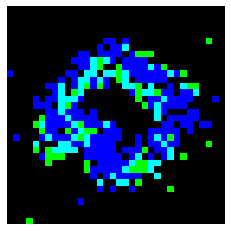

In [ ]:
import os
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

max_no = 10000/20

frames = []
dir = "/content/NMNIST/Train/6/01270.bin"
events = read_events(dir)
max_x = 33
max_y = 33
segmented_events = segment_events(events, 8, False)
for segment in segmented_events:
  intensity_map = np.array(get_intensity(segment, max_x, max_y))
  merged = np.array([np.zeros(shape=(34, 34)),intensity_map[0],intensity_map[1]])
  merged = np.moveaxis(merged, 0, -1)
  plt.imshow(merged)
  plt.axis('off')
  # plt.show()
  plt.savefig('tmp.png', bbox_inches='tight', pad_inches=0)
  frames.append(Image.open("/content/tmp.png"))

# Save into a GIF file that loops forever
frames[0].save('nmnist_train_6_01270_frame_integrated.gif', format='GIF',
               append_images=frames[1:],
               save_all=True,
               duration=300, loop=0)

In [ ]:
!rm -rf /content/datasets
!mkdir /content/datasets
!mkdir /content/datasets/DVS128Gesture
!unzip -q /content/drive/MyDrive/DVS128Gesture/'DVS  Gesture dataset.zip' -d /content/datasets/DVS128Gesture
!mv /content/datasets/DVS128Gesture/'DVS  Gesture dataset' /content/datasets/DVS128Gesture/download

In [ ]:
!pip -q install spikingjelly
from spikingjelly.datasets.dvs128_gesture import DVS128Gesture

root_dir = "/content/datasets/DVS128Gesture"
train_set = DVS128Gesture(root_dir, train=True, data_type='event')
test_set = DVS128Gesture(root_dir, train=False, data_type='event')

     |████████████████████████████████| 237 kB 9.1 MB/s 
The [/content/datasets/DVS128Gesture/download] directory for saving downloaded files already exists, check files...
Mkdir [/content/datasets/DVS128Gesture/extract].
Extract [/content/datasets/DVS128Gesture/download/DvsGesture.tar.gz] to [/content/datasets/DVS128Gesture/extract].
Mkdir [/content/datasets/DVS128Gesture/events_np].
Start to convert the origin data from [/content/datasets/DVS128Gesture/extract] to [/content/datasets/DVS128Gesture/events_np] in np.ndarray format.
Mkdir [('/content/datasets/DVS128Gesture/events_np/train', '/content/datasets/DVS128Gesture/events_np/test').
Mkdir ['5', '3', '9', '4', '10', '7', '8', '2', '0', '6', '1'] in [/content/datasets/DVS128Gesture/events_np/train] and ['5', '3', '9', '4', '10', '7', '8', '2', '0', '6', '1'] in [/content/datasets/DVS128Gesture/events_np/test].
Start the ThreadPoolExecutor with max workers = [2].
Start to split [/content/datasets/DVS128Gesture/extract/DvsGesture/use

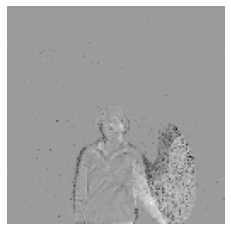

In [ ]:
import numpy as np
import os
from scipy import ndimage

frames = []
dir = "/content/datasets/DVS128Gesture/events_np/train/6/user15_lab_0.npz"
events = restructure_spikingjelly_events(dir)
segmented_events = segment_events(events, 20, False)
count = 0
for segment in segmented_events:
  intensity_map = np.fliplr(ndimage.rotate(np.array(get_intensity(segment, 128, 128)), -90))
  plt.imshow(intensity_map, cmap='gray')
  plt.axis('off')
  # plt.show()
  # plt.savefig('tmp.png', bbox_inches='tight', pad_inches=0)
  plt.savefig("tmp_{0}.png".format(count), bbox_inches='tight', pad_inches=0)
  # frames.append(Image.open("/content/tmp.png"))
  count += 1

# # Save into a GIF file that loops forever
# frames[0].save('dvs128_train_600_custom_frame_integrated.gif', format='GIF',
#                append_images=frames[1:],
#                save_all=True,
#                duration=300, loop=0)


In [ ]:
from PIL import Image
frames = []
for i in range(20):
  frames.append(Image.open("/content/tmp_{0}.png".format(i)))

# Save into a GIF file that loops forever
frames[0].save('dvs128_train_600_custom_frame_integrated.gif', format='GIF',
               append_images=frames[1:],
               save_all=True,
               duration=300, loop=0)